## Step 1 : Import libraries

In [21]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Step 2: Import File

In [57]:
filepath = r"C:\Users\welde\Documents\GitHub\AI-project\model\preprocessed_data\processed_train_en.tsv"
df = pd.read_csv(filepath, sep='\t')

## Step 3: Check about the dataframe
    

In [98]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sentence_id       830 non-null    object 
 1   label             830 non-null    object 
 2   solved_conflict   830 non-null    bool   
 3   sentence          830 non-null    object 
 4   word_count        830 non-null    int64  
 5   label_encoded     830 non-null    int64  
 6   sentence_length   830 non-null    int64  
 7   avg_tfidf         830 non-null    float64
 8   cluster           830 non-null    int32  
 9   pos_tags          830 non-null    object 
 10  pos_sequence      830 non-null    object 
 11  cleaned_sentence  830 non-null    object 
dtypes: bool(1), float64(1), int32(1), int64(3), object(6)
memory usage: 69.0+ KB


,sentence_id,label,solved_conflict,sentence,word_count,label_encoded,sentence_length,avg_tfidf,cluster,pos_tags,pos_sequence,cleaned_sentence
0,b9e1635a-72aa-467f-86d6-f56ef09f62c3,SUBJ,True,"[go, day, lead, world, recessionbuste]",5,1,5,0.000684,2,"[VERB, NOUN, VERB, NOUN, NOUN]",VERB NOUN VERB NOUN NOUN,"[go, day, lead, world, recessionbuste]"
1,f99b5143-70d2-494a-a2f5-c68f10d09d0a,OBJ,False,"[trend, expect, reverse, soon, month]",5,0,5,0.000688,2,"[NOUN, VERB, VERB, ADV, NOUN]",NOUN VERB VERB ADV NOUN,"[trend, expect, reverse, soon, month]"
2,4076639c-aa56-4202-ae0f-9d9217f8da68,OBJ,False,"[specious, point]",2,0,2,0.000431,2,"[ADJ, NOUN]",ADJ NOUN,"[specious, point]"
3,b057c366-698e-419d-a284-9b16d835c64e,OBJ,False,"[add, not, surprised, new, variant, altogether...",7,0,7,0.000803,3,"[VERB, PART, ADJ, ADJ, NOUN, ADV, VERB]",VERB PART ADJ ADJ NOUN ADV VERB,"[add, not, surprised, new, variant, altogether..."
4,a5a9645e-7850-41ba-90a2-5def725cd5b8,SUBJ,False,"[government, government, money]",3,1,3,0.000436,1,"[NOUN, NOUN, NOUN]",NOUN NOUN NOUN,"[government, government, money]"


# word frequency plot

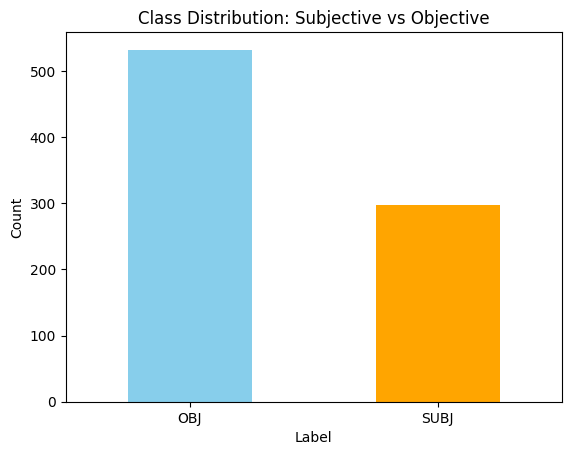

In [27]:
import matplotlib.pyplot as plt

# Count the number of SUBJ and OBJ
class_counts = df['label'].value_counts()

# Plot
class_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Class Distribution: Subjective vs Objective')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


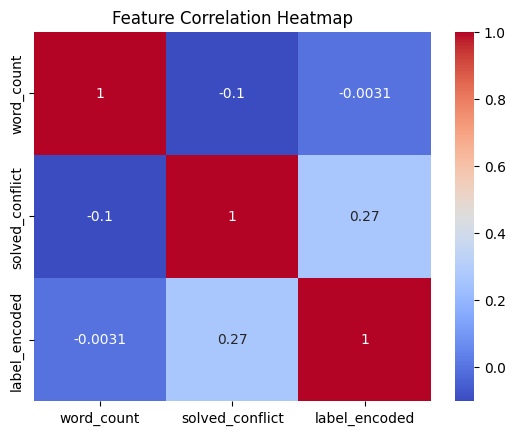

In [ ]:


# Encode label column as 0 (OBJ) and 1 (SUBJ)
df['label_encoded'] = df['label'].apply(lambda x: 1 if x == 'SUBJ' else 0)

# Select numerical columns for correlation
correlation_matrix = df[['word_count', 'solved_conflict', 'label_encoded']].corr()

# Plot heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


In [60]:
import ast

# Convert the string representation of lists into actual lists
df['sentence'] = df['sentence'].apply(ast.literal_eval)

# Verify the conversion
print(type(df['sentence'].iloc[0]))  # Should now print <class 'list'>
print(df['sentence'].iloc[0])       # Should print ['go', 'day', 'lead', 'world', 'recessionbuster']


<class 'list'>
['go', 'day', 'lead', 'world', 'recessionbuste']


## TF-IDF Vectorization

c:\Users\welde\miniconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


            Word      Score
1302  government  22.178370
2764       state  13.441971
3211        year  11.165693
1947         new  10.937593
2307      public  10.457957
2555         say  10.089686
2877     teacher   9.543416
1700        like   8.002747
687         cost   8.002593
1475    increase   7.923875


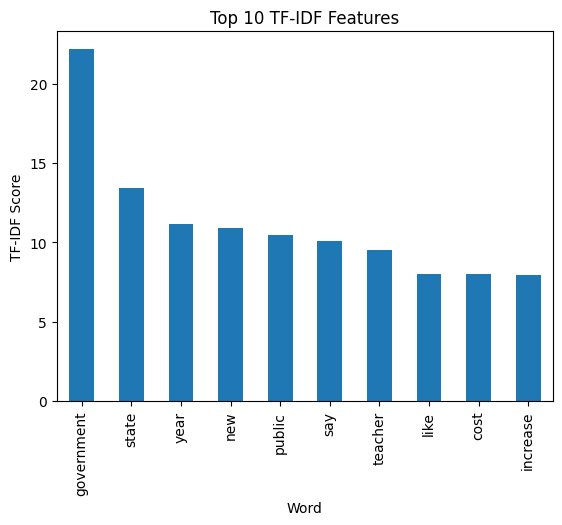

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt

# Define an identity tokenizer for pre-tokenized input
def identity_tokenizer(text):
    return text

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    tokenizer=identity_tokenizer,  # Use the pre-tokenized input
    lowercase=False,               # Data is already clean
    stop_words=None                # Stop words are already handled
)

# Fit and transform the tokenized data
X_tfidf = tfidf.fit_transform(df['sentence'])

# Extract and visualize TF-IDF scores
tfidf_scores = pd.DataFrame({
    'Word': tfidf.get_feature_names_out(),
    'Score': X_tfidf.toarray().sum(axis=0)
})

# Sort and display the top words
top_words = tfidf_scores.sort_values(by='Score', ascending=False).head(10)
print(top_words)

# Plot the results
top_words.plot(kind='bar', x='Word', y='Score', legend=False)
plt.title('Top 10 TF-IDF Features')
plt.ylabel('TF-IDF Score')
plt.xlabel('Word')
plt.show()


# most frequent words 

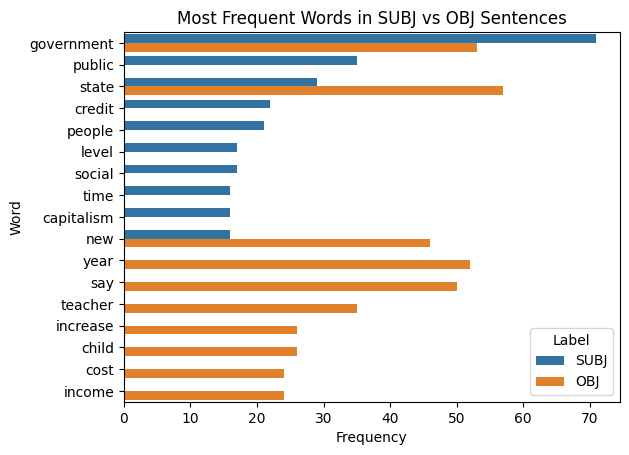

In [62]:
from collections import Counter
import pandas as pd

# Extract tokens from SUBJ and OBJ
subj_words = [word for tokens in df[df['label'] == 'SUBJ']['sentence'] for word in tokens]
obj_words = [word for tokens in df[df['label'] == 'OBJ']['sentence'] for word in tokens]

# Count top 10 words
subj_word_counts = Counter(subj_words).most_common(10)
obj_word_counts = Counter(obj_words).most_common(10)

# Create DataFrame for plotting
word_freq_df = pd.DataFrame({
    'Word': [x[0] for x in subj_word_counts + obj_word_counts],
    'Frequency': [x[1] for x in subj_word_counts + obj_word_counts],
    'Label': ['SUBJ'] * len(subj_word_counts) + ['OBJ'] * len(obj_word_counts)
})

# Plot
import seaborn as sns
sns.barplot(data=word_freq_df, x='Frequency', y='Word', hue='Label')
plt.title('Most Frequent Words in SUBJ vs OBJ Sentences')
plt.show()


# Topic Modeling

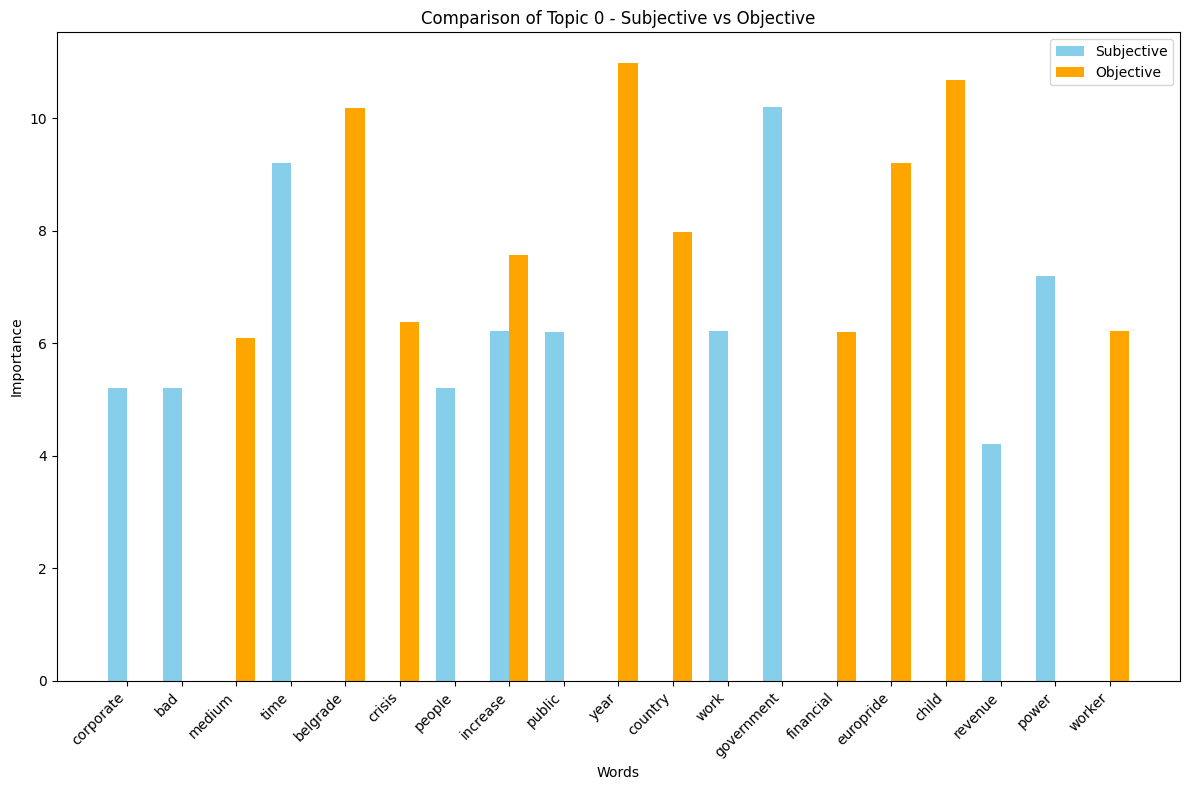

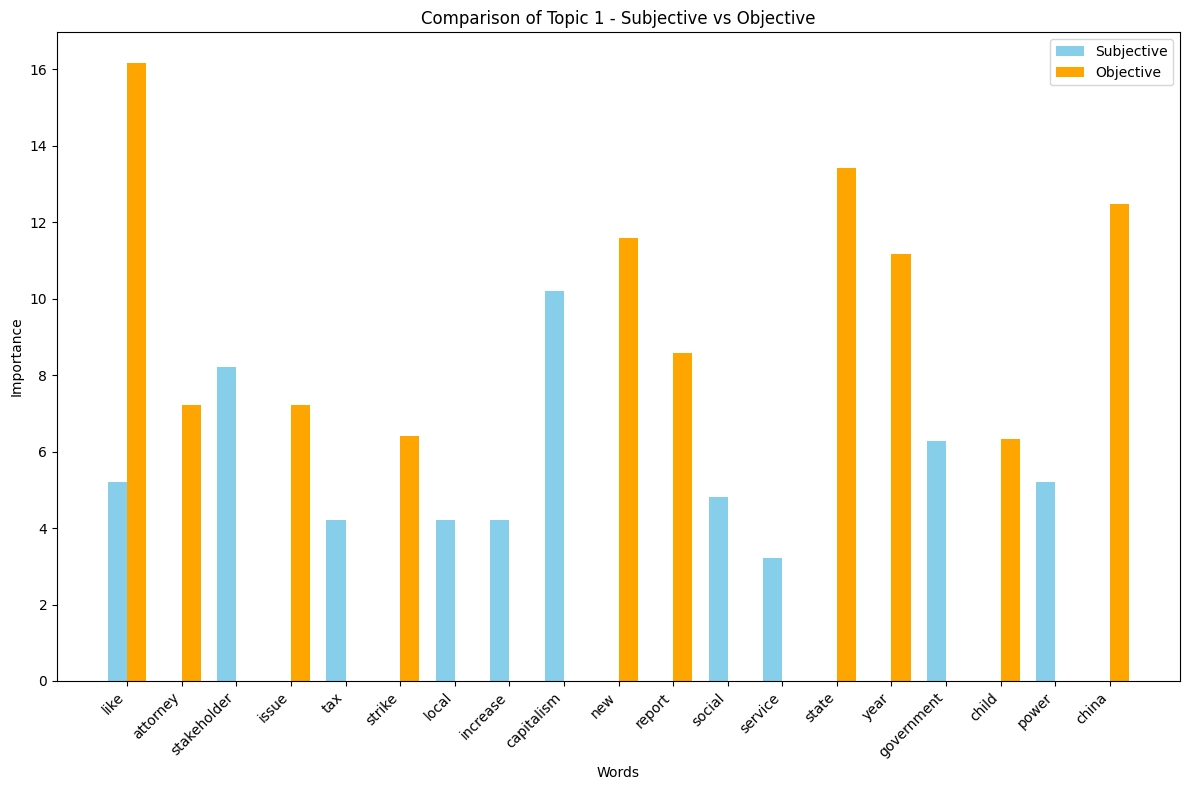

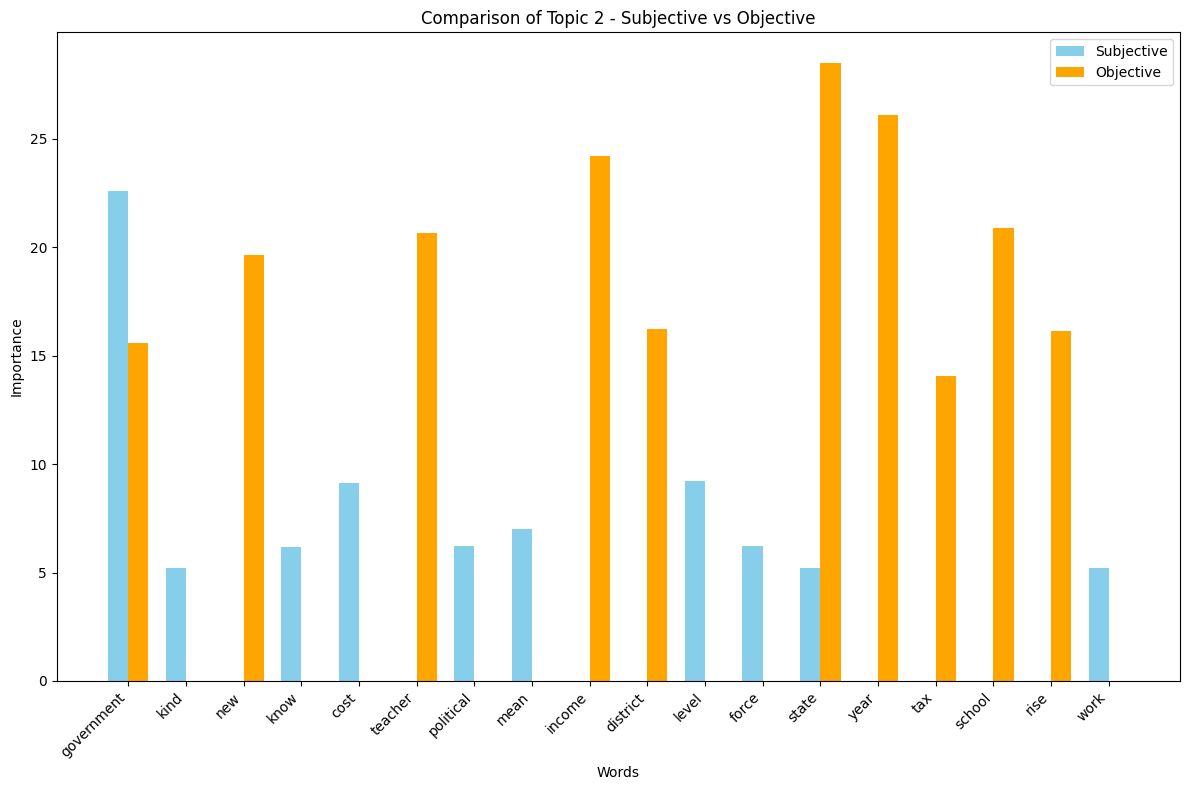

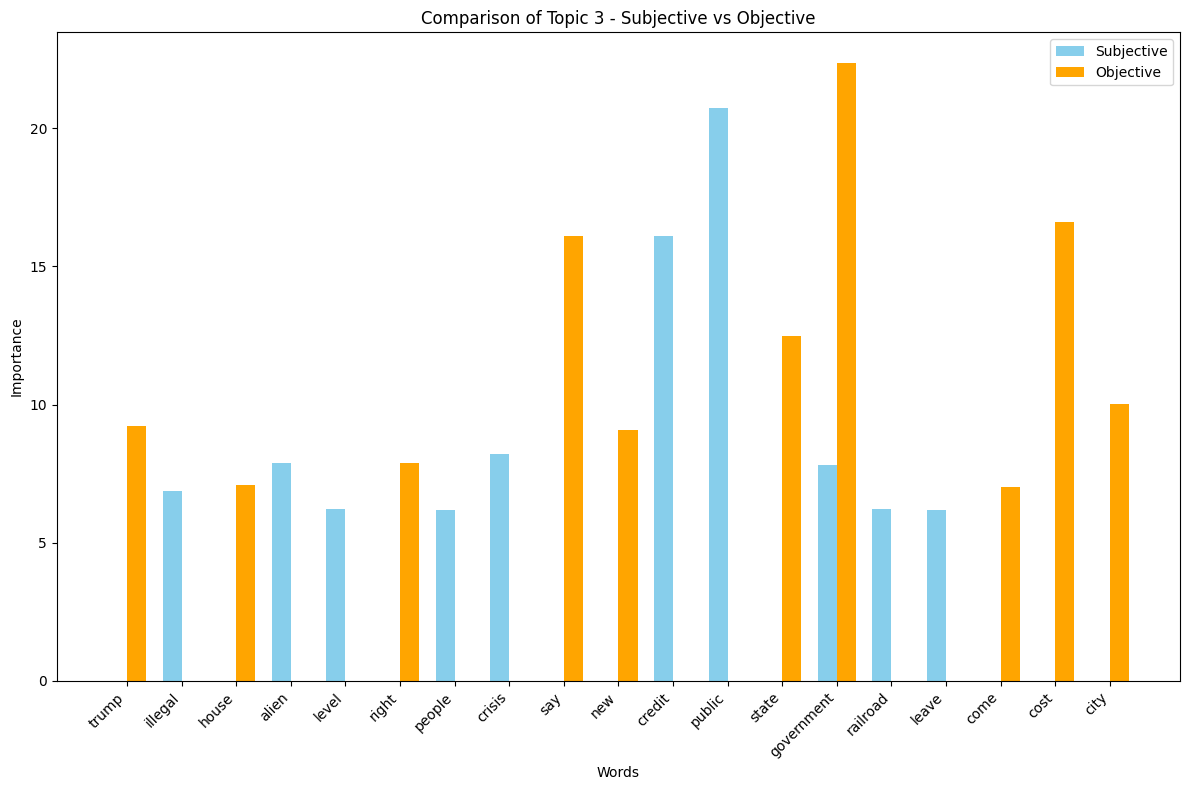

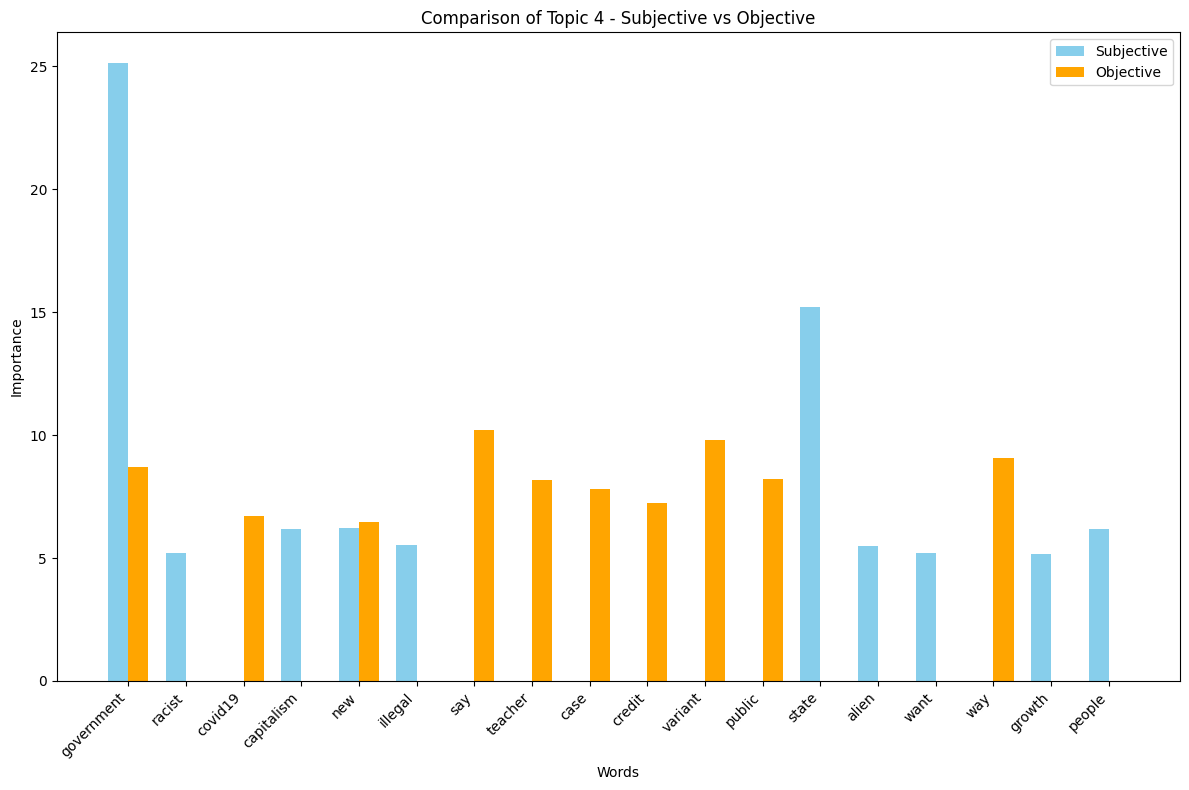

In [106]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import numpy as np

# Assuming `df` is your dataset
# Join tokens in 'sentence' into a single string for vectorization
df['processed_sentence'] = df['sentence'].apply(lambda x: " ".join(x))

# Separate subjective and objective sentences
subjective_sentences = df[df['label'] == 'SUBJ']
objective_sentences = df[df['label'] == 'OBJ']

# Function to extract LDA topics
def extract_topics(data, n_topics=5, n_top_words=10):
    # Vectorize the data
    vectorizer = CountVectorizer(max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(data['processed_sentence'])
    
    # Fit LDA model
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(X)
    
    # Extract topics and their top words
    feature_names = vectorizer.get_feature_names_out()
    topics = {}
    for idx, topic in enumerate(lda.components_):
        top_words_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_indices]
        top_weights = topic[top_words_indices]
        topics[idx] = {"words": top_words, "weights": top_weights}
    return topics

# Extract topics for subjective and objective sentences
n_topics = 5
subjective_topics = extract_topics(subjective_sentences, n_topics=n_topics)
objective_topics = extract_topics(objective_sentences, n_topics=n_topics)
n= 0
# Plot comparison of topics
for topic_idx in range(n_topics):
    subj_words = subjective_topics[topic_idx]["words"]
    subj_weights = subjective_topics[topic_idx]["weights"]
    obj_words = objective_topics[topic_idx]["words"]
    obj_weights = objective_topics[topic_idx]["weights"]
   
    # Align words for comparison
    all_words = list(set(subj_words + obj_words))
    subj_values = [subj_weights[subj_words.index(w)] if w in subj_words else 0 for w in all_words]
    obj_values = [obj_weights[obj_words.index(w)] if w in obj_words else 0 for w in all_words]
    
    # Create side-by-side bar chart
    x = np.arange(len(all_words))
    width = 0.35  # Width of bars
    
    plt.figure(figsize=(12, 8))
    plt.bar(x - width / 2, subj_values, width, label="Subjective", color="skyblue")
    plt.bar(x + width / 2, obj_values, width, label="Objective", color="orange")
    
    plt.xlabel("Words")
    plt.ylabel("Importance")
    plt.title(f"Comparison of Topic {topic_idx} - Subjective vs Objective")
    plt.xticks(ticks=x, labels=all_words, rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()


# word pair analysis

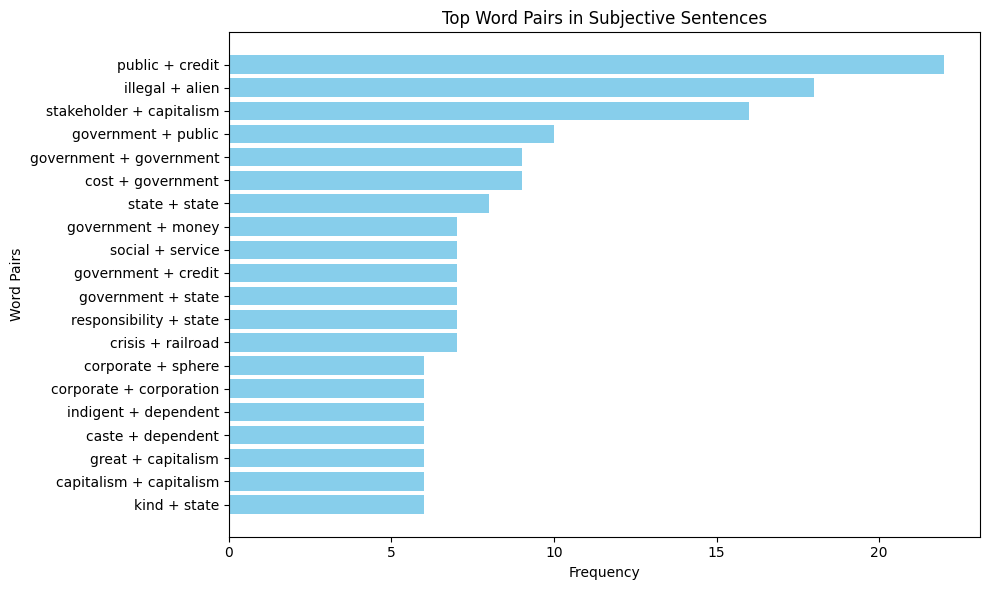

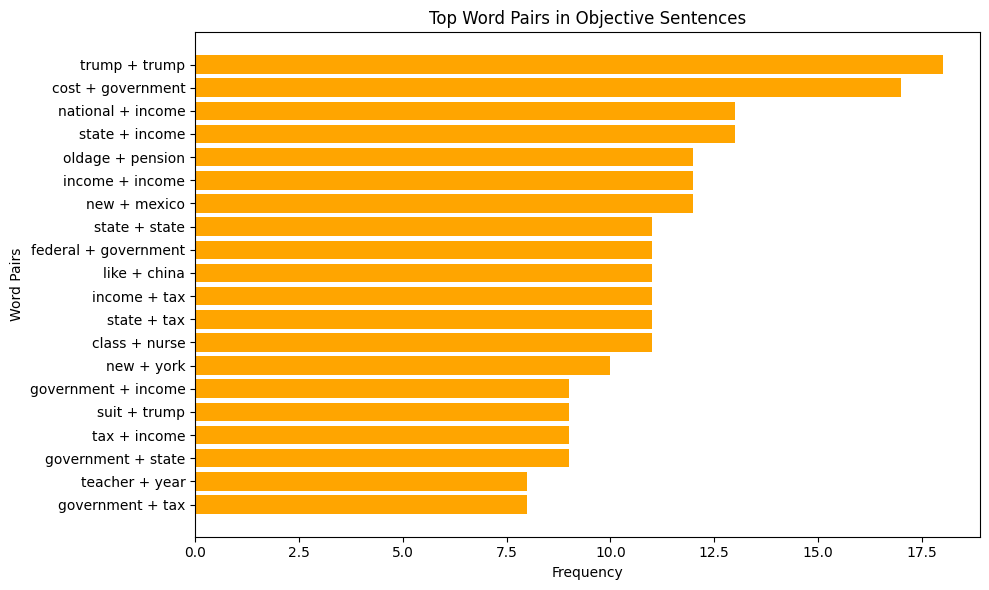

In [109]:
from collections import Counter
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt

# Function to create and plot a word pair network for a given category



# Extract word pair frequencies for subjective sentences
subj_word_pairs = [pair for sentence in subjective_data['sentence'] for pair in combinations(sentence, 2)]
subj_pair_counts = Counter(subj_word_pairs).most_common(20)

# Extract word pair frequencies for objective sentences
obj_word_pairs = [pair for sentence in objective_data['sentence'] for pair in combinations(sentence, 2)]
obj_pair_counts = Counter(obj_word_pairs).most_common(20)

# Plot word pair frequencies for subjective
plt.figure(figsize=(10, 6))
subj_pairs, subj_counts = zip(*subj_pair_counts)
subj_pairs = [" + ".join(pair) for pair in subj_pairs]
plt.barh(subj_pairs, subj_counts, color="skyblue")
plt.title("Top Word Pairs in Subjective Sentences")
plt.xlabel("Frequency")
plt.ylabel("Word Pairs")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Plot word pair frequencies for objective
plt.figure(figsize=(10, 6))
obj_pairs, obj_counts = zip(*obj_pair_counts)
obj_pairs = [" + ".join(pair) for pair in obj_pairs]
plt.barh(obj_pairs, obj_counts, color="orange")
plt.title("Top Word Pairs in Objective Sentences")
plt.xlabel("Frequency")
plt.ylabel("Word Pairs")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



3. Embedding Analysis (Word2Vec or Sentence Embeddings)
Use word embeddings (e.g., Word2Vec, GloVe, or Sentence Transformers) to capture semantic relationships between words or sentences. Then, cluster or visualize these embeddings to understand patterns.

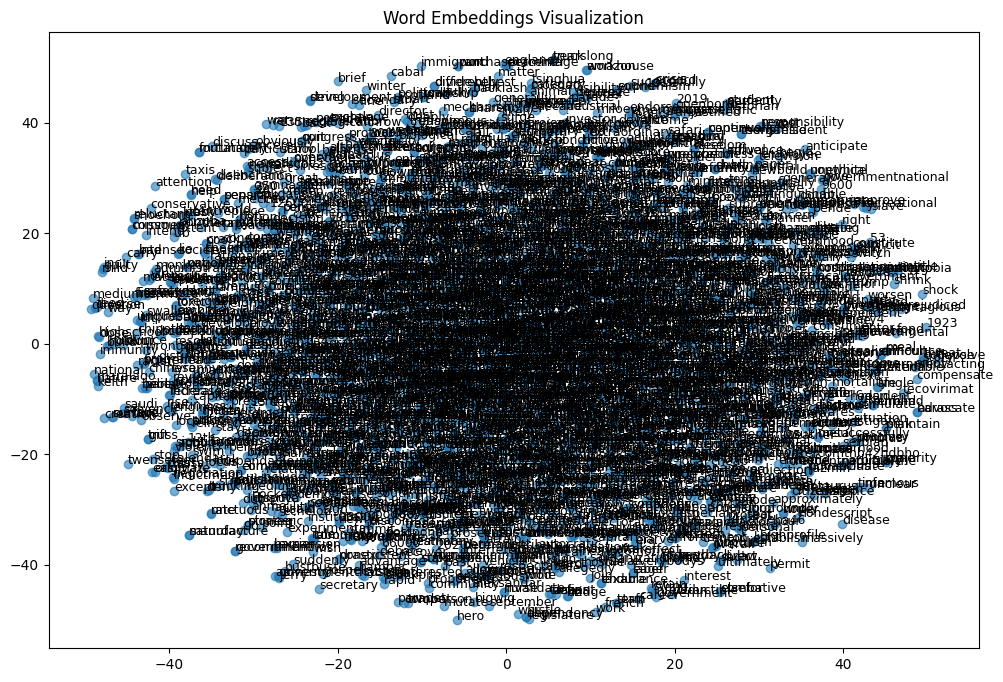

In [111]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from gensim.models import Word2Vec

# Train Word2Vec on your sentences
model = Word2Vec(sentences=df['sentence'], vector_size=100, window=5, min_count=1, workers=4)

# Extract word embeddings
words = list(model.wv.index_to_key)
word_vectors = model.wv[words]

# Reduce dimensionality for visualization (using t-SNE)
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(word_vectors)

# Plot the word embeddings
plt.figure(figsize=(12, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.6)
for i, word in enumerate(words):
    plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], word, fontsize=9)
plt.title("Word Embeddings Visualization")
plt.show()


# sentiment distribution

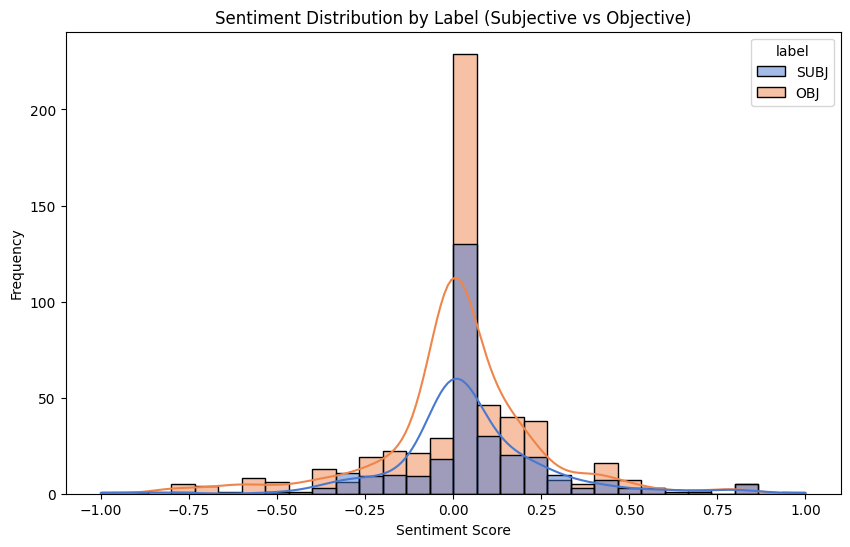

In [113]:

import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load spaCy model and add TextBlob sentiment analyzer
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("spacytextblob")

# Calculate sentiment for each sentence
def calculate_sentiment(sentence):
    doc = nlp(" ".join(sentence))  # Join tokenized sentence into text
    return doc._.blob.polarity  # Sentiment polarity (range: -1 to 1)

# Apply sentiment analysis to the dataset
df['sentiment'] = df['sentence'].apply(calculate_sentiment)

# Plot sentiment distribution by label
plt.figure(figsize=(10, 6))
sns.histplot(df, x='sentiment', hue='label', kde=True, palette="muted", bins=30)
plt.title("Sentiment Distribution by Label (Subjective vs Objective)")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()



7. Part-of-Speech (POS) Analysis
Examine the usage of different parts of speech (e.g., nouns, verbs, adjectives) in subjective vs. objective sentences.

In [86]:
import spacy
nlp = spacy.load('en_core_web_sm')
doc = nlp("This is another test.")
print([(token.text, token.pos_) for token in doc])



[('This', 'PRON'), ('is', 'AUX'), ('another', 'DET'), ('test', 'NOUN'), ('.', 'PUNCT')]


In [87]:
import spacy

# Load SpaCy's English model
nlp = spacy.load('en_core_web_sm')

# Function to extract POS tags from a tokenized sentence
def extract_pos(sentence):
    doc = nlp(" ".join(sentence))  # Join tokens into a sentence for SpaCy processing
    return [token.pos_ for token in doc]  # Extract POS tags

# Apply to subjective and objective sentences
df['pos_tags'] = df['sentence'].apply(extract_pos)

# Verify results
print(df[['sentence', 'pos_tags']].head())


                                            sentence  \
0             [go, day, lead, world, recessionbuste]   
1              [trend, expect, reverse, soon, month]   
2                                  [specious, point]   
3  [add, not, surprised, new, variant, altogether...   
4                    [government, government, money]   

                                  pos_tags  
0           [VERB, NOUN, VERB, NOUN, NOUN]  
1            [NOUN, VERB, VERB, ADV, NOUN]  
2                              [ADJ, NOUN]  
3  [VERB, PART, ADJ, ADJ, NOUN, ADV, VERB]  
4                       [NOUN, NOUN, NOUN]  


In [88]:
from collections import Counter

# Split dataset by label
subj_pos = [pos for tags in df[df['label'] == 'SUBJ']['pos_tags'] for pos in tags]
obj_pos = [pos for tags in df[df['label'] == 'OBJ']['pos_tags'] for pos in tags]

# Count POS frequencies
subj_pos_counter = Counter(subj_pos)
obj_pos_counter = Counter(obj_pos)

# Print the top 10 POS tags
print("Subjective POS Frequencies:", subj_pos_counter.most_common(10))
print("Objective POS Frequencies:", obj_pos_counter.most_common(10))


Subjective POS Frequencies: [('NOUN', 1658), ('ADJ', 649), ('VERB', 489), ('PROPN', 310), ('ADV', 147), ('AUX', 29), ('NUM', 22), ('ADP', 17), ('PART', 13), ('INTJ', 8)]
Objective POS Frequencies: [('NOUN', 2863), ('PROPN', 985), ('ADJ', 879), ('VERB', 822), ('ADV', 194), ('NUM', 180), ('ADP', 32), ('AUX', 25), ('PART', 12), ('INTJ', 7)]


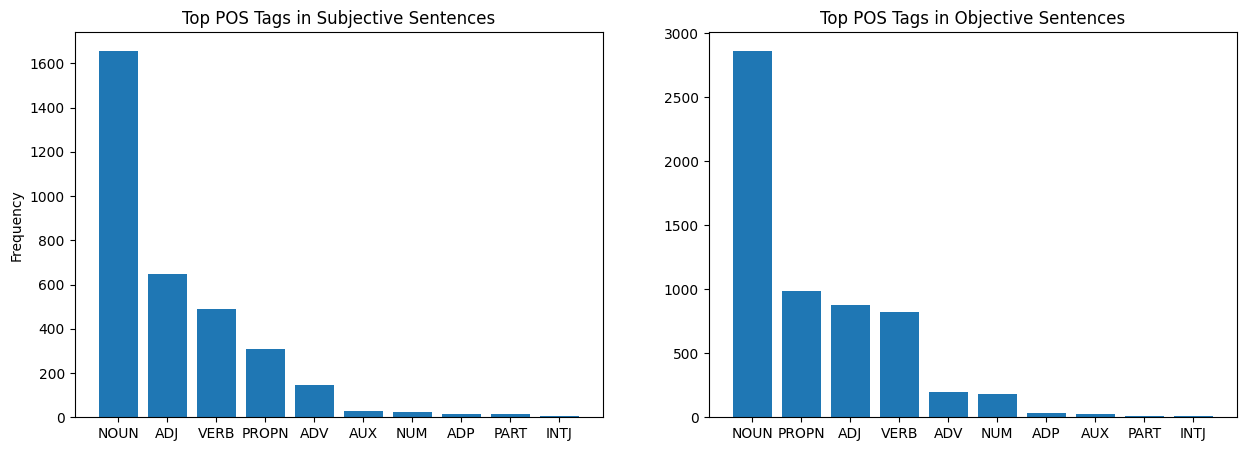

In [89]:
import matplotlib.pyplot as plt

# Convert POS counts to lists for plotting
subj_labels, subj_values = zip(*subj_pos_counter.most_common(10))
obj_labels, obj_values = zip(*obj_pos_counter.most_common(10))

# Plot POS frequencies side by side
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].bar(subj_labels, subj_values)
ax[0].set_title('Top POS Tags in Subjective Sentences')
ax[0].set_ylabel('Frequency')

ax[1].bar(obj_labels, obj_values)
ax[1].set_title('Top POS Tags in Objective Sentences')

plt.show()


In [115]:
# Function to extract POS sequences from a sentence
def extract_pos_sequence(sentence):
    doc = nlp(" ".join(sentence))  # Join tokens into a string
    return " ".join([token.pos_ for token in doc])  # Create a POS sequence as a string

# Add POS sequences to the dataframe
df['pos_sequence'] = df['sentence'].apply(extract_pos_sequence)

# Verify the extracted sequences
print(df[['sentence', 'pos_sequence']].head())


                                            sentence  \
0             [go, day, lead, world, recessionbuste]   
1              [trend, expect, reverse, soon, month]   
2                                  [specious, point]   
3  [add, not, surprised, new, variant, altogether...   
4                    [government, government, money]   

                      pos_sequence  
0         VERB NOUN VERB NOUN NOUN  
1          NOUN VERB VERB ADV NOUN  
2                         ADJ NOUN  
3  VERB PART ADJ ADJ NOUN ADV VERB  
4                   NOUN NOUN NOUN  


In [91]:
from collections import Counter

# Count POS sequence frequencies for SUBJ and OBJ
subj_pos_sequences = df[df['label'] == 'SUBJ']['pos_sequence']
obj_pos_sequences = df[df['label'] == 'OBJ']['pos_sequence']

subj_pos_sequence_counter = Counter(subj_pos_sequences)
obj_pos_sequence_counter = Counter(obj_pos_sequences)

# Display the most common sequences
print("Most Common POS Sequences in Subjective Sentences:")
print(subj_pos_sequence_counter.most_common(10))

print("\nMost Common POS Sequences in Objective Sentences:")
print(obj_pos_sequence_counter.most_common(10))


Most Common POS Sequences in Subjective Sentences:
[('NOUN NOUN NOUN', 5), ('NOUN NOUN', 4), ('NOUN', 3), ('ADJ NOUN NOUN', 2), ('PROPN PROPN', 2), ('VERB', 2), ('NOUN NOUN NOUN NOUN NOUN NOUN NOUN', 2), ('PROPN NOUN', 2), ('VERB NOUN VERB NOUN NOUN', 1), ('VERB ADJ NOUN NOUN NOUN NOUN NOUN VERB ADJ NOUN VERB NOUN VERB NOUN NOUN NOUN VERB NOUN NOUN NOUN', 1)]

Most Common POS Sequences in Objective Sentences:
[('NOUN NOUN', 9), ('NOUN', 7), ('VERB', 6), ('ADJ NOUN', 3), ('VERB NOUN NOUN', 3), ('NOUN NOUN NOUN NOUN NOUN ADJ NOUN', 2), ('NOUN NOUN NOUN', 2), ('PROPN PROPN VERB', 2), ('', 2), ('NOUN VERB NOUN NOUN', 2)]


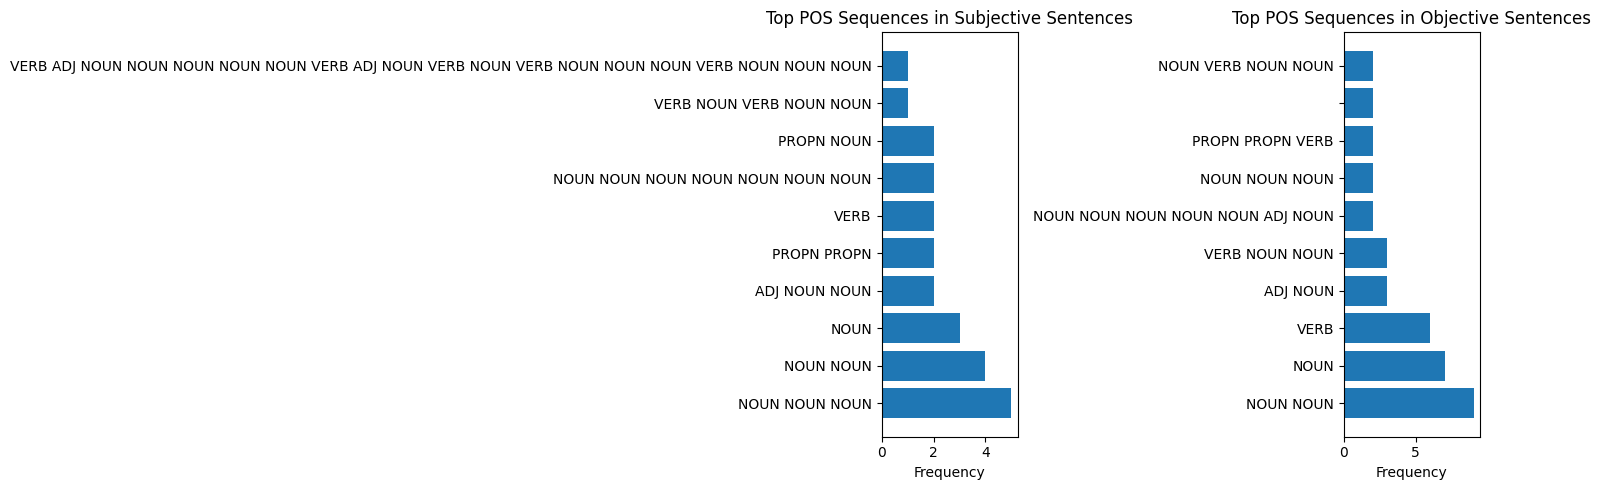

In [92]:
import matplotlib.pyplot as plt

# Get the top 10 POS sequences for SUBJ and OBJ
subj_top_sequences = subj_pos_sequence_counter.most_common(10)
obj_top_sequences = obj_pos_sequence_counter.most_common(10)

# Separate sequences and frequencies
subj_labels, subj_counts = zip(*subj_top_sequences)
obj_labels, obj_counts = zip(*obj_top_sequences)

# Plot side-by-side bar charts
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Subjective POS sequences
ax[0].barh(subj_labels, subj_counts)
ax[0].set_title("Top POS Sequences in Subjective Sentences")
ax[0].set_xlabel("Frequency")

# Objective POS sequences
ax[1].barh(obj_labels, obj_counts)
ax[1].set_title("Top POS Sequences in Objective Sentences")
ax[1].set_xlabel("Frequency")

plt.tight_layout()
plt.show()


In [118]:
df.describe()
df.head()


,sentence_id,label,solved_conflict,sentence,word_count,label_encoded,sentence_length,avg_tfidf,cluster,pos_tags,pos_sequence,cleaned_sentence,processed_sentence,Assigned_Topic,Topic_Label,sentiment
0,b9e1635a-72aa-467f-86d6-f56ef09f62c3,SUBJ,True,"[go, day, lead, world, recessionbuste]",5,1,5,0.000684,2,"[VERB, NOUN, VERB, NOUN, NOUN]",VERB NOUN VERB NOUN NOUN,"[go, day, lead, world, recessionbuste]",go day lead world recessionbuste,0,OBJ,0.000000
1,f99b5143-70d2-494a-a2f5-c68f10d09d0a,OBJ,False,"[trend, expect, reverse, soon, month]",5,0,5,0.000688,2,"[NOUN, VERB, VERB, ADV, NOUN]",NOUN VERB VERB ADV NOUN,"[trend, expect, reverse, soon, month]",trend expect reverse soon month,0,OBJ,0.000000
2,4076639c-aa56-4202-ae0f-9d9217f8da68,OBJ,False,"[specious, point]",2,0,2,0.000431,2,"[ADJ, NOUN]",ADJ NOUN,"[specious, point]",specious point,1,SUBJ,0.000000
3,b057c366-698e-419d-a284-9b16d835c64e,OBJ,False,"[add, not, surprised, new, variant, altogether...",7,0,7,0.000803,3,"[VERB, PART, ADJ, ADJ, NOUN, ADV, VERB]",VERB PART ADJ ADJ NOUN ADV VERB,"[add, not, surprised, new, variant, altogether...",add not surprised new variant altogether fall,0,OBJ,0.043182
4,a5a9645e-7850-41ba-90a2-5def725cd5b8,SUBJ,False,"[government, government, money]",3,1,3,0.000436,1,"[NOUN, NOUN, NOUN]",NOUN NOUN NOUN,"[government, government, money]",government government money,1,SUBJ,0.000000


In [120]:
# Save DataFrame as a TSV file
df.to_csv('proccessed_train_en_feature_extracted.tsv', sep='\t', index=False)
